<a href="https://colab.research.google.com/github/TattaBio/gLM2/blob/main/categorical_jacobian_gLM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Categorical Jacobian on gLM2
Adapted from @sokrypton

In [1]:
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'
import os
from typing import List
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting
from bokeh.transform import linear_cmap
from bokeh.plotting import figure, show
from bokeh.palettes import viridis
from transformers import AutoTokenizer, AutoModelForMaskedLM
from matplotlib.colors import to_hex

bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
#@markdown ## Flags
fast = False # @param {type:"boolean"}
#@markdown - only perturb the `mask` token

In [3]:
#@markdown ## setup gLM2_650M
import os
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM

MODEL_NAME = "tattabio/gLM2_650M"
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
NUC_TOKENS = tuple(range(29, 33)) # 4 nucleotides a,t,c,g
AA_TOKENS = tuple(range(4,24)) # 20 amino acids
NUM_TOKENS = len(AA_TOKENS) + len(NUC_TOKENS)

model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME, trust_remote_code=True).eval().to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
MASK_TOKEN_ID = tokenizer.mask_token_id

def create_figure(contact_df, tokens: List[str]):
  tools = "hover,save,pan,box_zoom,reset,wheel_zoom"
  seqlen = len(tokens)
  contact_df['i_token'] = contact_df['i'] + ': ' + contact_df['i'].astype(int).map(lambda x: tokens[x-1])
  contact_df['j_token'] = contact_df['j'] + ': ' + contact_df['j'].astype(int).map(lambda x: tokens[x-1])
  p = figure(title="COEVOLUTION",
            x_range=[str(x) for x in range(1,seqlen+1)],
            y_range=[str(x) for x in range(1,seqlen+1)][::-1],
            width=800, height=800,
            tools=tools, toolbar_location='below',
            tooltips=[('i', '@i_token'), ('j', '@j_token'), ('value', '@value')])

  cmap = plt.colormaps["Blues"]
  blues = [to_hex(cmap(i)) for i in np.linspace(0, 1, 256)]
  r = p.rect(x="i", y="j", width=1, height=1, source=contact_df,
            fill_color=linear_cmap('value', blues, low=contact_df.value.min(), high=np.percentile(contact_df.value, 99)),
            line_color=None)
  p.xaxis.visible = False  # Hide the x-axis
  p.yaxis.visible = False  # Hide the x-axis
  return p


def contact_to_dataframe(con):
  sequence_length = con.shape[0]
  idx = [str(i) for i in np.arange(1, sequence_length + 1)]
  df = pd.DataFrame(con, index=idx, columns=idx)
  df = df.stack().reset_index()
  df.columns = ['i', 'j', 'value']
  return df

def jac_to_contact(jac, symm=True, center=True, diag="remove", apc=True):

  X = jac.copy()
  Lx,Ax,Ly,Ay = X.shape

  if center:
    for i in range(4):
      if X.shape[i] > 1:
        X -= X.mean(i,keepdims=True)

  contacts = np.sqrt(np.square(X).sum((1,3)))

  if symm and (Ax != 20 or Ay != 20):
    contacts = (contacts + contacts.T)/2

  if diag == "remove":
    np.fill_diagonal(contacts,0)

  if diag == "normalize":
    contacts_diag = np.diag(contacts)
    contacts = contacts / np.sqrt(contacts_diag[:,None] * contacts_diag[None,:])

  if apc:
    ap = contacts.sum(0,keepdims=True) * contacts.sum(1, keepdims=True) / contacts.sum()
    contacts = contacts - ap

  if diag == "remove":
    np.fill_diagonal(contacts,0)

  return contacts


def get_categorical_jacobian(sequence: str, fast: bool = False):
  all_tokens = NUC_TOKENS + AA_TOKENS
  num_tokens = len(all_tokens)

  input_ids = torch.tensor(tokenizer.encode(sequence), dtype=torch.int)
  tokens = tokenizer.convert_ids_to_tokens(input_ids)
  seqlen = input_ids.shape[0]
  # [seqlen, 1, seqlen, 1].
  is_nuc_pos = torch.isin(input_ids, torch.tensor(NUC_TOKENS)).view(-1, 1, 1, 1).repeat(1, 1, seqlen, 1)
  # [1, num_tokens, 1, num_tokens].
  is_nuc_token = torch.isin(torch.tensor(all_tokens), torch.tensor(NUC_TOKENS)).view(1, -1, 1, 1).repeat(1, 1, 1, num_tokens)
  # [seqlen, 1, seqlen, 1].
  is_aa_pos = torch.isin(input_ids, torch.tensor(AA_TOKENS)).view(-1, 1, 1, 1).repeat(1, 1, seqlen, 1)
  # [1, num_tokens, 1, num_tokens].
  is_aa_token = torch.isin(torch.tensor(all_tokens), torch.tensor(AA_TOKENS)).view(1, -1, 1, 1).repeat(1, 1, 1, num_tokens)

  input_ids = input_ids.unsqueeze(0).to(DEVICE)
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
    f = lambda x:model(x)[0][..., all_tokens].cpu().float()

    x = torch.clone(input_ids).to(DEVICE)
    ln = x.shape[1]

    fx = f(x)[0]
    if fast:
      fx_h = torch.zeros((ln, 1 , ln, num_tokens), dtype=torch.float32)
    else:
      fx_h = torch.zeros((ln,num_tokens,ln,num_tokens),dtype=torch.float32)
      x = torch.tile(x,[num_tokens,1])
    with tqdm(total=ln, bar_format=TQDM_BAR_FORMAT) as pbar:
      for n in range(ln): # for each position
        x_h = torch.clone(x)
        if fast:
          x_h[:, n] = MASK_TOKEN_ID
        else:
          x_h[:, n] = torch.tensor(all_tokens)
        fx_h[n] = f(x_h)
        pbar.update(1)
    jac = fx_h-fx
    valid_nuc = is_nuc_pos & is_nuc_token
    valid_aa = is_aa_pos & is_aa_token
    # Zero out other modality
    jac = torch.where(valid_nuc | valid_aa, jac, 0.0)
    contact = jac_to_contact(jac.numpy())
  return jac, contact, tokens

## Protein-Protein Interaction Example (ModAC)

In [9]:
MOD_A = "MFL"
MOD_C = "MRL"

sequence = f"<+>{MOD_A}<+>{MOD_C}"
J, contact, tokens = get_categorical_jacobian(sequence, fast=fast)
df = contact_to_dataframe(contact)
p = create_figure(df, tokens)
show(p)


/var/folders/y2/g6ndzk_n1m5c3xddfs2cskrc0000gt/T/ipykernel_2140/1592385954.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
/Users/ievapudz/miniconda3/envs/gLM/lib/python3.9/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


  0%|          | 0/8 [elapsed: 00:00 remaining: ?]

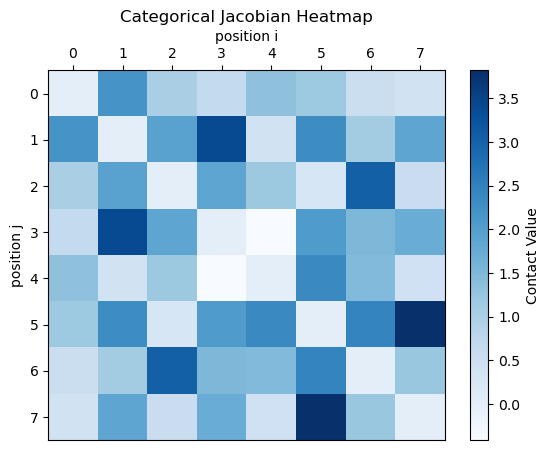

In [21]:
# Convert the dataframe to a pivot table for heatmap
pivot_df = df.pivot(index='i', columns='j', values='value')

# Create a heatmap using matplotlib
fig, ax = plt.subplots()
ax.invert_yaxis()
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
cax = ax.imshow(pivot_df, cmap=plt.colormaps["Blues"], aspect='auto')
ax.set_xlabel('position i')
ax.set_ylabel('position j')
ax.set_title('Categorical Jacobian Heatmap')

plt.colorbar(cax, ax=ax, label='Contact Value')

plt.show()